_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: FILL IN YOUR NAMES HERE

# Coding Lab 8



In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rc("savefig", dpi=72)
sns.set_style("whitegrid")
%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-07-01 18:42:46CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.23.0

sklearn: 1.4.2

numpy     : 1.26.4
scipy     : 1.13.0
seaborn   : 0.13.2
matplotlib: 3.8.4

Watermark: 2.4.3



# Task 1: Implement entropy estimators


*Grading: 5 pts (basic) + 1 pts (advanced) + 3 pts (bonus)*

## General framework

Entropy is defined as 

$$
H[p] = -\sum_x p_x \log p_x
$$

where $p_x = p(x=X)$. Here we assume that $X$ is a discrete random variable and that there are finitely many states $K$ that $X$ can take.

We are interested in the entropy of discrete random variables, because of its relationship with mutual information:

$$
I[X|Y] = H[X] - H[X|Y]
$$

If we can estimate the entropy well, we can estimate the mutual information well. An application in neuroscience would be estimating the mutual information between a spike train modeled as a sequence of $1$ s and $0$ s (e.g. $(0,1,0,1,1)$) and a discrete set of stimuli.

Note that a multivariate binary distribution modeling a spike train can always be mapped to a discrete univariate distribution, $\mathbb{Z}_2 \longrightarrow \mathbb{Z_+}$, by interpreting each binary state $z \in \mathbb{Z}_2$ as its corresponding binary number and computing $f(z) = \sum_i 2^{i} z_i$.

As discussed in the lecture, the problem is that one always underestimates the true entropy of a distribution from samples. In this exercise you are meant to implement different estimators for discrete entropy and evaluate them on different discrete distributions:

* Uniform distribution: $p(x=X) = \frac{1}{K}$

* "Zipf's law"- distribution: $p(x=X) = \frac{1}{Z x} $, where $Z = \sum_k 1/k$

There is a really good series of blog posts about discrete entropy estimation to be found [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html), [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html) and [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-3.html). 

Make sure you use binary logarithms throughout.


## Implementation of the estimators

Implement the

* maximum likelihood estimator (1 pt)
* miller-maddow corrected estimator (1 pt)
* jack-knife corrected estimator (2 pt)
* coverage adjusted estimator (1 pt).

When implementing the jack-knife estimator, you may want to restrict the amount of resampling for performance reasons e.g. to 1000, even if more samples are available. By definition, $0\log0=0$. Adapt the interfaces as needed for your implementation.

In addition, implement or use one of the following more advanced estimators (1+3 pts, extra points if you use your own implementation):

* [JVHW estimator](https://arxiv.org/abs/1406.6956) with code on [github](https://github.com/EEthinker/JVHW_Entropy_Estimators/tree/master/Python)
* [Unseen estimator](http://papers.nips.cc/paper/5170-estimating-the-unseen-improved-estimators-for-entropy-and-other-properties) (includes Matlab code in Supplementary)
* [Best Upper Bounds estimator](http://www.mitpressjournals.org/doi/abs/10.1162/089976603321780272) (Matlab code available on Ilias)

For this part, you are allowed to use an existing implementation as well.


## Basic
*Grading: 5 pts*

### MLE

*Grading: 1 pts*

$H_{ML}= -\sum_{x}\hat{p}(x)log(\hat{p}(x))$

In [3]:
def entropy_mle(phat):
    """Maximum likelihood or plug-in estimator of discrete entropy

    Parameter
    ---------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    Return
    ------
    H: float
        Entropy estimate
    """
    # insert your code here (1 pt)
    H = -np.sum([0 if x == 0 else x * np.log2(x) for x in phat])

    return H

### Miller-Maddow corrected

*Grading: 1 pts*

$H_{MM}=H_{ML}+\frac{\hat{d}-1}{2n}$ 

$ \hat{d} = \#[\hat{p}(x)>0]$ 



In [4]:
def entropy_mm(phat, n):
    """Miller-Maddow corrected estimator of discrete entropy

    Parameters
    ----------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    n:  int
        Number of samples


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)

    dhat = np.sum(phat > 0)
    H = entropy_mle(phat) + (dhat - 1) / (2 * n)

    return H

### Jack-knife corrected

*Grading: 2 pts*

$\hat{H}_{JK} = N\hat{H}_{ML} - (N-1)\hat{H}_{ML}^{(.)}$ 

$\hat{H}_{ML}^{(.)} = <H_{ML}^{\lnot i}>$

In [5]:
def entropy_jk(x, edges):
    """Jack-knife corrected estimator of discrete entropy

    Parameters
    ----------
    x: np.array, shape=(n_samples, )
        Samples

    edges: np.array, shape=(n_bins, )
        Histogram bin edges


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (2 pt)

    N_MAX_RESAMPLE = 1000
    N_SAMPLES = len(x)

    n_resample = min(N_SAMPLES, N_MAX_RESAMPLE)

    H_I = np.zeros(n_resample)
    for i in range(n_resample):
        phat_i, _ = np.histogram(np.delete(x, i), bins=edges, density=True)
        H_I[i] = entropy_mle(phat_i)

    phat, _ = np.histogram(x, bins=edges, density=True)
    H = n_resample * entropy_mle(phat) - (n_resample - 1) * np.average(H_I)

    return H

### Coverage-adjusted

*Grading: 1 pts*

$C = 1 - \frac{\# f_{i}=1}{N}$

$\hat{P}_{C}= \hat{P}\cdot C$ 

$H_{CA}= -\sum_{x}\frac{\hat{P_{C}}(x)log(\hat{P_{C}}(x))}{1-(1-\hat{P_{C}}(x))^N}$



In [6]:
def entropy_cae(phat, n):
    """coverage-adjusted estimator of discrete entropy

    Parameters
    ----------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    n: int
        Number of samples.


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)

    C = 1 - np.sum(phat == 1 / n) / n

    H = -np.sum(
        [
            0 if x * C == 0 else (x * C * np.log2(x * C)) / (1 - (1 - C * x) ** n)
            for x in phat
        ]
    )

    return H

## Advanced
*Grading: 1 + 3 pts*

### JVHW
*Grading: 1 pts*

In [7]:
import scipy.io as sio

poly_entro = None


def entropy_jvhw(samp):
    """Proposed JVHW estimate of Shannon entropy (in bits) of the input sample

    This function returns a scalar JVHW estimate of the entropy of samp when
    samp is a vector, or returns a row vector containing the JVHW estimate of
    each column of samp when samp is a matrix.

    Input:
    ----- samp: a vector or matrix which can only contain integers. The input
                data type can be any interger classes such as uint8/int8/
                uint16/int16/uint32/int32/uint64/int64, or floating-point
                such as single/double.
    Output:
    ----- est: the entropy (in bits) of the input vector or that of each column
               of the input matrix. The output data type is double.
    """
    samp = formalize_sample(samp)
    [n, wid] = samp.shape
    n = float(n)

    # The order of polynomial is no more than 22 because otherwise floating-point error occurs
    order = min(4 + int(np.ceil(1.2 * np.log(n))), 22)
    global poly_entro
    if poly_entro is None:
        poly_entro = sio.loadmat("poly_coeff_entro.mat")["poly_entro"]
    coeff = poly_entro[order - 1, 0][0]

    f = fingerprint(samp)

    prob = np.arange(1, f.shape[0] + 1) / n

    # Piecewise linear/quadratic fit of c_1
    V1 = np.array([0.3303, 0.4679])
    V2 = np.array([-0.530556484842359, 1.09787328176926, 0.184831781602259])
    f1nonzero = f[0] > 0
    c_1 = np.zeros(wid)

    with np.errstate(divide="ignore", invalid="ignore"):
        if n >= order and f1nonzero.any():
            if n < 200:
                c_1[f1nonzero] = np.polyval(V1, np.log(n / f[0, f1nonzero]))
            else:
                n2f1_small = f1nonzero & (np.log(n / f[0]) <= 1.5)
                n2f1_large = f1nonzero & (np.log(n / f[0]) > 1.5)
                c_1[n2f1_small] = np.polyval(V2, np.log(n / f[0, n2f1_small]))
                c_1[n2f1_large] = np.polyval(V1, np.log(n / f[0, n2f1_large]))

            # make sure nonzero threshold is higher than 1/n
            c_1[f1nonzero] = np.maximum(c_1[f1nonzero], 1 / (1.9 * np.log(n)))

        prob_mat = entro_mat(prob, n, coeff, c_1)

    return np.sum(f * prob_mat, axis=0) / np.log(2)


def entro_mat(x, n, g_coeff, c_1):
    # g_coeff = {g0, g1, g2, ..., g_K}, K: the order of best polynomial approximation,
    K = len(g_coeff) - 1
    thres = 4 * c_1 * np.log(n) / n
    T, X = np.meshgrid(thres, x)
    ratio = np.minimum(np.maximum(2 * X / T - 1, 0), 1)
    q = np.arange(K).reshape((1, 1, K))
    g = g_coeff.reshape((1, 1, K + 1))
    MLE = -X * np.log(X) + 1 / (2 * n)
    polyApp = np.sum(
        np.concatenate(
            (T[..., None], ((n * X)[..., None] - q) / (T[..., None] * (n - q))), axis=2
        ).cumprod(axis=2)
        * g,
        axis=2,
    ) - X * np.log(T)
    polyfail = np.isnan(polyApp) | np.isinf(polyApp)
    polyApp[polyfail] = MLE[polyfail]
    output = ratio * MLE + (1 - ratio) * polyApp
    return np.maximum(output, 0)


def formalize_sample(samp):
    samp = np.array(samp)
    if np.any(samp != np.fix(samp)):
        raise ValueError("Input sample must only contain integers.")
    if samp.ndim == 1 or samp.ndim == 2 and samp.shape[0] == 1:
        samp = samp.reshape((samp.size, 1))
    return samp


def fingerprint(samp):
    """A memory-efficient algorithm for computing fingerprint when wid is
    large, e.g., wid = 100
    """
    wid = samp.shape[1]

    d = np.r_[
        np.full((1, wid), True, dtype=bool),
        np.diff(np.sort(samp, axis=0), 1, 0) != 0,
        np.full((1, wid), True, dtype=bool),
    ]

    f_col = []
    f_max = 0

    for k in range(wid):
        a = np.diff(np.flatnonzero(d[:, k]))
        a_max = a.max()
        hist, _ = np.histogram(a, bins=a_max, range=(1, a_max + 1))
        f_col.append(hist)
        if a_max > f_max:
            f_max = a_max

    return np.array([np.r_[col, [0] * (f_max - len(col))] for col in f_col]).T

### Bonus points: Unseen or Best Upper Bounds estimator
*Grading: 3 bonus pts*

In [8]:
# insert your code here

# ------------------------------------------
# Port Unseen or Best Upper Bounds estimator
# from MatLab to Python. (3 bonus pts)
# ------------------------------------------

# Task 2: Distributions
*Grading: 4 pts*

## Uniform distribution
*Grading: 2 pts*

In [9]:
D = 10
N = 2**D

p = 1 / N * np.ones(N)  # true distribution

H = -np.sum(p * np.log2(p))  # true entropy

print(H)

10.0


Sample from the uniform distribution using sample sizes of 100 and 10000. Plot the true distribution and the sampled distributions. What do you notice? (2 pt)

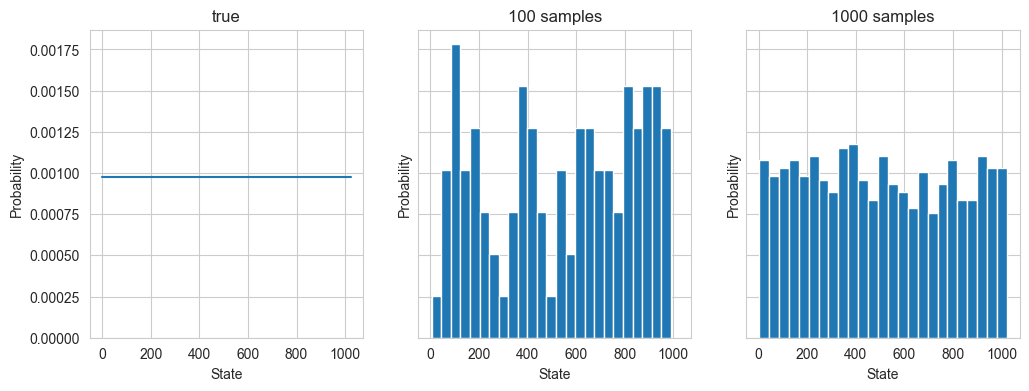

In [10]:
# insert your code here
rng = np.random.default_rng(0)

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 100 (0.5 pts)
# ------------------------------------
sample_100 = np.random.uniform(0, N - 1, 100)
# ------------------------------------
# Sample from the uniform distribution
# using sample size of 10000 (0.5 pts)
# ------------------------------------
sample_1000 = np.random.uniform(0, N - 1, 1000)
# ------------------------------------
# Plot the true distribution and
# the sampled distributions. (0.5 pts)
# ------------------------------------

N_BINS = 25
titles = ["true", "100 samples", "1000 samples"]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)

axs[0].plot(p)
axs[1].hist(sample_100, density=True, bins=N_BINS)
axs[2].hist(sample_1000, density=True, bins=N_BINS)

for i, ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.set_ylabel("Probability")
    ax.set_xlabel("State")

plt.show()

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [11]:
sample_sizes = np.round(np.logspace(1, 5, num=10))
n_runs = 30
rng = np.random.default_rng(1)

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sample_sizes), n_runs))
h_mm = np.zeros((len(sample_sizes), n_runs))
h_jk = np.zeros((len(sample_sizes), n_runs))
h_cae = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):

        # ------------------------------------
        # Sample from the uniform distribution
        # with different sample size (0.5 pts)
        # ------------------------------------

        # insert your code here
        x = np.random.uniform(0, N, size=int(S))
        phat, _ = np.histogram(x, bins=edges, density=True)

        h_mle[i, j] = entropy_mle(phat)
        h_mm[i, j] = entropy_mm(phat, S)
        h_cae[i, j] = entropy_cae(phat, S)
        h_jk[i, j] = entropy_jk(x, edges)
        x = [int(i) for i in x]
        h_jvhw[i, j] = entropy_jvhw(x)

/var/folders/5j/y5kkrfqd203frqztz88nnmqr0000gn/T/ipykernel_4111/3570682809.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h_jvhw[i, j] = entropy_jvhw(x)


Plot the resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

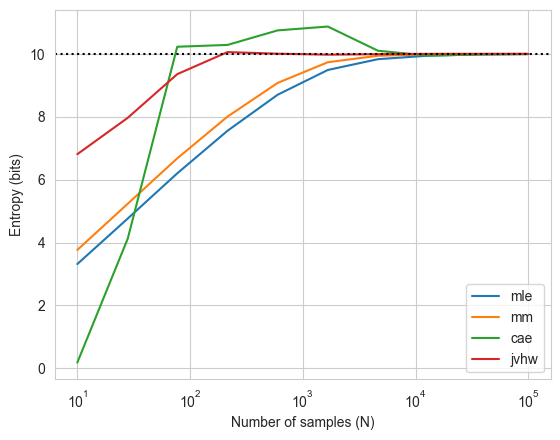

In [12]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle, axis=1), label="mle")
plt.semilogx(sample_sizes, np.mean(h_mm, axis=1), label="mm")
plt.semilogx(sample_sizes, np.mean(h_cae, axis=1), label="cae")
plt.semilogx(sample_sizes, np.mean(h_jk, axis=1), label="jk")
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label="jvhw")

# plot h_unseen or h_bub here if you implemented them.

plt.axhline(H, color="black", linestyle=":")
plt.xlabel("Number of samples (N)")
plt.ylabel("Entropy (bits)")
plt.legend()
plt.show()

## Zipf distribution
*Grading: 2 pts*

[Zipf's law ](https://en.wikipedia.org/wiki/Zipf%27s_law) refers to a family of power law like distributions for which $p_k \sim 1/k^d$. We will simply use $d=1$ here.   

Adapt the framework above to sample from a Zipf distribution and evaluate the estimators for this case. Are there differences to the uniform case? (2 pts)

In [13]:
D = 10
N = 2**D

p = 1 / (np.arange(0, N) + 1)  # true distribution
p = p / np.sum(p)

H = -np.sum(p * np.log2(p))  # true entropy

print(H)

7.510649703297878


Sample from the Zipf distribution using sample sizes of 100 and 10000. In this case, the function `choice` of numpys random number generator is very helpful for sampling. Plot the true distribution and the sampled distributions. What do you notice? 

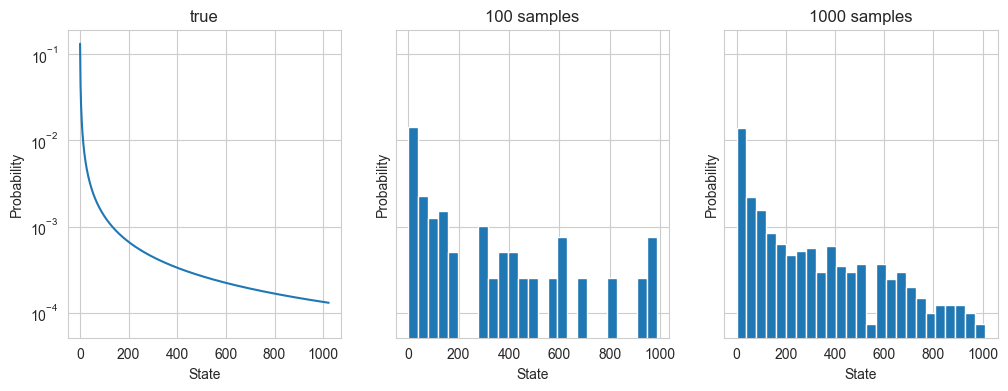

In [14]:
# insert your code here
rng = np.random.default_rng(2)

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 100 (0.5 pts)
# ---------------------------------------
sample_100 = np.random.choice(range(0, N), size=100, p=p)

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 10000 (0.5 pts)
# ---------------------------------------
sample_1000 = np.random.choice(range(0, N), size=1000, p=p)

# ---------------------------------------
# Plot the true distribution and the sampled
# distributions. (0.5 pts)
# ---------------------------------------

N_BINS = 25
titles = ["true", "100 samples", "1000 samples"]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
axs[0].plot(p)
axs[1].hist(sample_100, density=True, bins=25)
axs[2].hist(sample_1000, density=True, bins=25)

for i, ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.set_ylabel("Probability")
    ax.set_xlabel("State")

axs[0].set_yscale("log")

plt.show()

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [15]:
sample_sizes = np.round(np.logspace(1, 5, num=10))
n_runs = 30
rng = np.random.default_rng(3)

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sample_sizes), n_runs))
h_mm = np.zeros((len(sample_sizes), n_runs))
h_jk = np.zeros((len(sample_sizes), n_runs))
h_cae = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):

        # ---------------------------------------
        # Sample from the Zipf distribution
        # with different sample size (0.5 pts)
        # ---------------------------------------

        # insert your code here
        x = np.random.choice(range(0, N), size=int(S), p=p)
        phat, edges = np.histogram(x, bins=N, density=True)

        h_mle[i, j] = entropy_mle(phat)
        h_mm[i, j] = entropy_mm(phat, S)
        h_cae[i, j] = entropy_cae(phat, S)
        h_jk[i, j] = entropy_jk(x, edges)
        x = [int(i) for i in x]
        h_jvhw[i, j] = entropy_jvhw(x)

KeyboardInterrupt: 

Plot resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

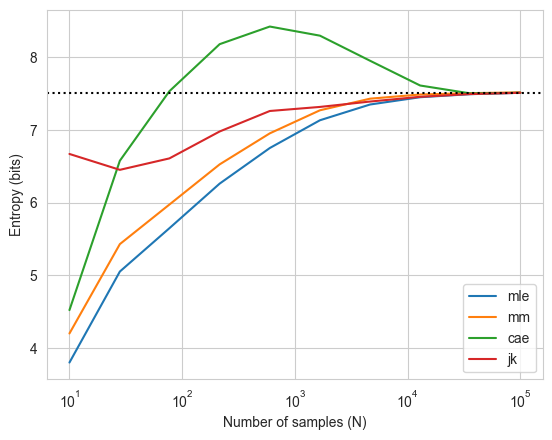

In [ ]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle, axis=1), label="mle")
plt.semilogx(sample_sizes, np.mean(h_mm, axis=1), label="mm")
plt.semilogx(sample_sizes, np.mean(h_cae, axis=1), label="cae")
plt.semilogx(sample_sizes, np.mean(h_jk, axis=1), label="jk")
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label="jvhw")

# plot h_unseen or h_bub here if you implemented them.

plt.axhline(H, color="black", linestyle=":")
plt.xlabel("Number of samples (N)")
plt.ylabel("Entropy (bits)")
plt.legend()
plt.show()